In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import optuna

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<div style="
  border-top: 4px solid #A970FF;
  padding: 16px 20px;
  background-color: #1a1a1a;
  color: white;
  border-radius: 8px;
  font-family: 'Segoe UI', sans-serif;
  line-height: 1.6;
">
  <h3 style="color: #A970FF; margin-top: 0;">📘 Dataset Columns</h3>
  <ul style="padding-left: 18px; margin: 10px 0;">
    <li><strong>id</strong>: Unique identifier for each row (only in the test set).</li>
    <li><strong>age</strong>: Age of the client (numeric).</li>
    <li><strong>job</strong>: Type of job (e.g., admin., technician, services).</li>
    <li><strong>marital</strong>: Marital status (married, single, divorced).</li>
    <li><strong>education</strong>: Education level (e.g., primary, secondary, tertiary).</li>
    <li><strong>default</strong>: Whether the client has credit in default (yes/no).</li>
    <li><strong>balance</strong>: Average yearly balance (numeric).</li>
    <li><strong>housing</strong>: Whether the client has a housing loan (yes/no).</li>
    <li><strong>loan</strong>: Whether the client has a personal loan (yes/no).</li>
    <li><strong>contact</strong>: Contact communication type (cellular etc).</li>
    <li><strong>day</strong>: Last contact day.</li>
    <li><strong>month</strong>: Last contact month.</li>
    <li><strong>duration</strong>: Last contact duration, in seconds.</li>
    <li><strong>campaign</strong>: Number of contacts during this campaign.</li>
    <li><strong>pdays</strong>: Days since the client was last contacted.</li>
    <li><strong>previous</strong>: Number of contacts before this campaign.</li>
    <li><strong>poutcome</strong>: Outcome of the previous marketing campaign.</li>
    <li><strong>y</strong>: Target; whether the client subscribed to a term deposit (1 = yes, 0 = no).</li>
  </ul>
</div>

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier,StackingClassifier,VotingClassifier
from lightgbm import LGBMClassifier

import joblib

import warnings 
warnings.filterwarnings('ignore')

# Importing Data

In [3]:
data_tr = pd.read_csv('/Users/marpinipavansrikar/Desktop/Kaggle_Competitions/playground-series-s5e8/train.csv')
data_tr.head(3)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0


In [4]:
data_tr.shape

(750000, 18)

In [5]:
data_te = pd.read_csv('/Users/marpinipavansrikar/Desktop/Kaggle_Competitions/playground-series-s5e8/test.csv')
data_te.head(3)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown


In [6]:
data_te.shape

(250000, 17)

In [7]:
data = pd.concat([data_tr,data_te],axis=0)
data

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0.0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0.0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0.0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0.0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,management,married,tertiary,no,0,yes,no,cellular,18,nov,65,2,-1,0,unknown,NaN
249996,999996,40,services,married,unknown,no,522,yes,no,cellular,19,nov,531,1,189,1,failure,NaN
249997,999997,63,retired,married,primary,no,33,no,no,cellular,3,jul,178,1,92,8,success,NaN
249998,999998,50,blue-collar,married,primary,no,2629,yes,no,unknown,30,may,163,2,-1,0,unknown,NaN


# Null Values

*  Check for null values using the function **isnull()**.

*  If there any null values they can be further filled by using the function **SimpleImputer()** using which categorical columns can be filled by setting parameter  *stratagy* to mostfrequent else for numerical by setting it to mean.

*  Here in the case of our data there are null values with label 'unknown' .

<Axes: >

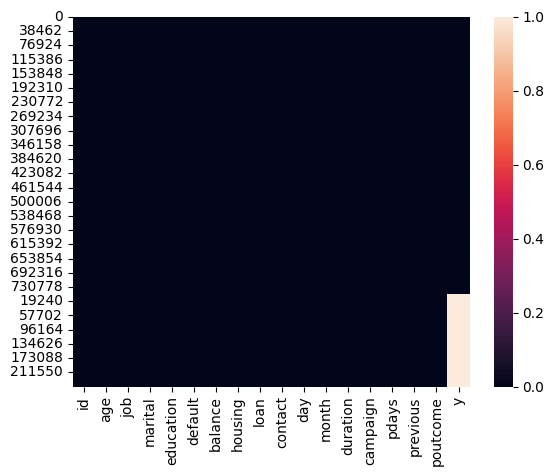

In [8]:
sns.heatmap(data.isnull())

In [9]:
data.drop(['poutcome','contact'],axis =1 ,inplace = True)

In [10]:
data.isnull().sum()

id                0
age               0
job               0
marital           0
education         0
default           0
balance           0
housing           0
loan              0
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
y            250000
dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 249999
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id         1000000 non-null  int64  
 1   age        1000000 non-null  int64  
 2   job        1000000 non-null  object 
 3   marital    1000000 non-null  object 
 4   education  1000000 non-null  object 
 5   default    1000000 non-null  object 
 6   balance    1000000 non-null  int64  
 7   housing    1000000 non-null  object 
 8   loan       1000000 non-null  object 
 9   day        1000000 non-null  int64  
 10  month      1000000 non-null  object 
 11  duration   1000000 non-null  int64  
 12  campaign   1000000 non-null  int64  
 13  pdays      1000000 non-null  int64  
 14  previous   1000000 non-null  int64  
 15  y          750000 non-null   float64
dtypes: float64(1), int64(8), object(7)
memory usage: 129.7+ MB


In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1000000.0,499999.500000,288675.278932,0.0,249999.75,499999.5,749999.25,999999.0
age,1000000.0,40.927879,10.094523,18.0,33.00,39.0,48.00,95.0
balance,1000000.0,1202.407136,2812.750998,-8019.0,0.00,634.0,1390.00,99717.0
day,1000000.0,16.116924,8.252748,1.0,9.00,17.0,21.00,31.0
duration,1000000.0,256.007423,272.268420,1.0,91.00,133.0,359.00,4918.0
campaign,1000000.0,2.576143,2.716302,1.0,1.00,2.0,3.00,63.0
pdays,1000000.0,22.379557,77.219149,-1.0,-1.00,-1.0,-1.00,871.0
previous,1000000.0,0.299841,1.348254,0.0,0.00,0.0,0.00,200.0
y,750000.0,0.120651,0.325721,0.0,0.00,0.0,0.00,1.0


In [13]:
categorical_cols = data.select_dtypes(include=['object']).columns
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'month'], dtype='object')

In [14]:
for i in categorical_cols :
    print(i)
    print(data[i].unique())
    print('\n')

job
['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur'
 'self-employed' 'unknown' 'services' 'retired' 'housemaid' 'unemployed']


marital
['married' 'single' 'divorced']


education
['secondary' 'primary' 'tertiary' 'unknown']


default
['no' 'yes']


housing
['no' 'yes']


loan
['no' 'yes']


month
['aug' 'jun' 'may' 'feb' 'apr' 'nov' 'jul' 'jan' 'oct' 'mar' 'sep' 'dec']




# Outliers Detection

<Axes: xlabel='balance'>

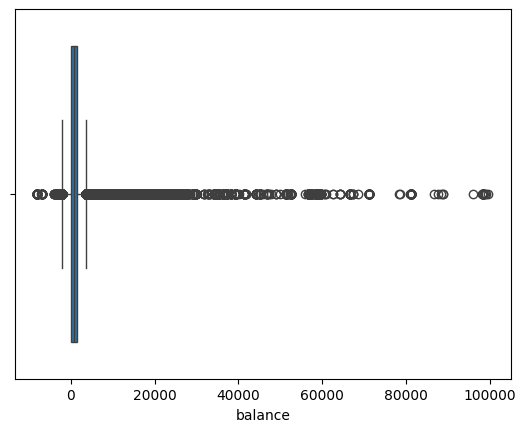

In [15]:
sns.boxplot(x = 'balance',data=data_tr)

# Encoding Categorical Columns

In [16]:
encoder = OrdinalEncoder()

data[categorical_cols] = encoder.fit_transform(data[categorical_cols])
#data.drop(categorical_cols,inplace=True,axis=1)
data

,id,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,0,42,9.0,1.0,1.0,0.0,7,0.0,0.0,25,1.0,117,3,-1,0,0.0
1,1,38,1.0,1.0,1.0,0.0,514,0.0,0.0,18,6.0,185,1,-1,0,0.0
2,2,36,1.0,1.0,1.0,0.0,602,1.0,0.0,14,8.0,111,2,-1,0,0.0
3,3,27,8.0,2.0,1.0,0.0,34,1.0,0.0,28,8.0,10,2,-1,0,0.0
4,4,26,9.0,1.0,1.0,0.0,889,1.0,0.0,3,3.0,902,1,-1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,4.0,1.0,2.0,0.0,0,1.0,0.0,18,9.0,65,2,-1,0,NaN
249996,999996,40,7.0,1.0,3.0,0.0,522,1.0,0.0,19,9.0,531,1,189,1,NaN
249997,999997,63,5.0,1.0,0.0,0.0,33,0.0,0.0,3,5.0,178,1,92,8,NaN
249998,999998,50,1.0,1.0,0.0,0.0,2629,1.0,0.0,30,8.0,163,2,-1,0,NaN


In [17]:
# encoder = OneHotEncoder(drop = 'first')

# data[encoder.get_feature_names_out()] = pd.DataFrame(encoder.fit_transform(data[categorical_cols]).toarray(),columns = encoder.get_feature_names_out())
# data.drop(categorical_cols,axis=1,inplace=True)

In [18]:
data.head()

,id,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,0,42,9.0,1.0,1.0,0.0,7,0.0,0.0,25,1.0,117,3,-1,0,0.0
1,1,38,1.0,1.0,1.0,0.0,514,0.0,0.0,18,6.0,185,1,-1,0,0.0
2,2,36,1.0,1.0,1.0,0.0,602,1.0,0.0,14,8.0,111,2,-1,0,0.0
3,3,27,8.0,2.0,1.0,0.0,34,1.0,0.0,28,8.0,10,2,-1,0,0.0
4,4,26,9.0,1.0,1.0,0.0,889,1.0,0.0,3,3.0,902,1,-1,0,1.0


# Splitting Data

In [19]:
data_te=data[data['y'].isnull()]
data_tr=data[~data['y'].isnull()]

In [20]:
data_tr.head(3)

,id,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,0,42,9.0,1.0,1.0,0.0,7,0.0,0.0,25,1.0,117,3,-1,0,0.0
1,1,38,1.0,1.0,1.0,0.0,514,0.0,0.0,18,6.0,185,1,-1,0,0.0
2,2,36,1.0,1.0,1.0,0.0,602,1.0,0.0,14,8.0,111,2,-1,0,0.0


In [21]:
data_tr.shape

(750000, 16)

In [22]:
data_te.drop('y',axis = 1,inplace = True)
data_te.head(3)

,id,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous
0,750000,32,1.0,1.0,1.0,0.0,1397,1.0,0.0,21,8.0,224,1,-1,0
1,750001,44,4.0,1.0,2.0,0.0,23,1.0,0.0,3,0.0,586,2,-1,0
2,750002,36,6.0,1.0,0.0,0.0,46,1.0,1.0,13,8.0,111,2,-1,0


In [23]:
data_te.shape

(250000, 15)

In [24]:
X = data_tr.drop('y',axis = 1)
y = data_tr['y']

X.shape , y.shape

((750000, 15), (750000,))

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Hyper Tuning

In [42]:
def objective_xgb(trial):
    params_xgb = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 5),
        "n_estimators": 1000,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "n_jobs": -1,
        "random_state": 42
    }

    model_xgb = XGBClassifier(**params_xgb)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model_xgb, X, y, scoring='roc_auc', cv=skf, n_jobs=-1)

    return scores.mean()

In [43]:
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=60,show_progress_bar=True)
optuna.logging.set_verbosity(optuna.logging.INFO)

print(study_xgb.best_params)

[I 2025-08-04 13:24:57,357] A new study created in memory with name: no-name-8b251741-0896-4687-95d5-7623e96c1634


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-08-04 13:25:34,933] Trial 0 finished with value: 0.9637338313536564 and parameters: {'learning_rate': 0.21088843237473806, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 4.319292515045423, 'subsample': 0.8299898499018857, 'colsample_bytree': 0.9243070935756637, 'reg_lambda': 2.32848404880676, 'reg_alpha': 0.2899846852208975, 'scale_pos_weight': 3}. Best is trial 0 with value: 0.9637338313536564.
[I 2025-08-04 13:26:08,624] Trial 1 finished with value: 0.963978610826611 and parameters: {'learning_rate': 0.23812087596650475, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 3.902459294694548, 'subsample': 0.561209353290236, 'colsample_bytree': 0.7327856206308165, 'reg_lambda': 5.0278476278416395, 'reg_alpha': 0.749115223151459, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.963978610826611.
[I 2025-08-04 13:26:57,155] Trial 2 finished with value: 0.9637259268252945 and parameters: {'learning_rate': 0.21099306107047494, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.3193

In [44]:
print("Best AUC:", study_xgb.best_value)
print("Best Parameters:")
print(study_xgb.best_params)

Best AUC: 0.9658946627074059
Best Parameters:
{'learning_rate': 0.02397985537156955, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 0.6280818324265819, 'subsample': 0.9293528161387496, 'colsample_bytree': 0.5021162296258401, 'reg_lambda': 9.97647162591141, 'reg_alpha': 0.5337726666739991, 'scale_pos_weight': 1}


In [45]:
optuna.visualization.plot_optimization_history(study_xgb)

In [46]:
# LGBMClassifier

def objective_lgbm(trial):
    params_lgbm = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 5),
        "n_estimators": 1000,
        "objective": "binary",
        "boosting_type": "gbdt",
        "n_jobs": -1,
        "random_state": 42
    }

    model_lgb = LGBMClassifier(**params_lgbm)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model_lgb, X, y, scoring='roc_auc', cv=skf, n_jobs=-1)

    return scores.mean()

In [47]:
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=60,show_progress_bar=True)
optuna.logging.set_verbosity(optuna.logging.INFO)

print(study_lgbm.best_params)

[I 2025-08-04 14:24:44,079] A new study created in memory with name: no-name-c37ee452-f84e-4caa-b6c9-30646d6867f2


  0%|          | 0/60 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 60326, number of negative: 439674
[LightGBM] [Info] Number of positive: 60325, number of negative: 439675
[LightGBM] [Info] Number of positive: 60325, number of negative: 439675
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1248
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120652 -> initscore=-1.986270
[LightGBM] [Info] Start training from score -1.986270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1248
[LightGBM] [Info] Number of data poi

In [48]:
print("Best AUC:", study_lgbm.best_value)
print("Best Parameters:")
print(study_lgbm.best_params)

Best AUC: 0.9660675435996612
Best Parameters:
{'learning_rate': 0.11235175929137245, 'max_depth': 14, 'min_child_weight': 7, 'subsample': 0.5941717562234573, 'colsample_bytree': 0.6379404167499119, 'reg_lambda': 8.227997337974575, 'reg_alpha': 0.6782738955642913, 'scale_pos_weight': 1}


In [50]:
optuna.visualization.plot_optimization_history(study_lgbm)

In [51]:
optuna.visualization.plot_parallel_coordinate(study_lgbm)

In [52]:
optuna.visualization.plot_slice(study_lgbm,params=['learning_rate','max_depth','min_child_weight','subsample'])

In [53]:
optuna.visualization.plot_param_importances(study_lgbm)

In [58]:
#CatBoostClassifier

def objective_cat(trial):
    params = {
        "iterations": 300,  
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.2),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 5),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 5),
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        "random_seed": 42,
        "verbose": 0
    }

    model = CatBoostClassifier(**params)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train,
                  eval_set=(X_val, y_val),
                  early_stopping_rounds=15,
                  verbose=0)

        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        auc_scores.append(auc)

    return np.mean(auc_scores)

In [60]:
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_cat, n_trials=30,show_progress_bar=True)
optuna.logging.set_verbosity(optuna.logging.INFO)

print(study_cat.best_params)

[I 2025-08-04 15:13:43,492] A new study created in memory with name: no-name-5314c039-37dc-4077-b219-69cb76bc1f03


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-08-04 15:15:17,565] Trial 0 finished with value: 0.9632969730439612 and parameters: {'learning_rate': 0.17675114335392728, 'depth': 10, 'l2_leaf_reg': 3.746846545384398, 'bagging_temperature': 0.9924728945388014, 'random_strength': 4.182482609647955, 'scale_pos_weight': 2.6638451776562526}. Best is trial 0 with value: 0.9632969730439612.
[I 2025-08-04 15:16:10,389] Trial 1 finished with value: 0.956054788578694 and parameters: {'learning_rate': 0.060864708488019295, 'depth': 5, 'l2_leaf_reg': 3.669577784161971, 'bagging_temperature': 0.5870441918618025, 'random_strength': 5.328321584409915, 'scale_pos_weight': 2.8716341563811985}. Best is trial 0 with value: 0.9632969730439612.
[I 2025-08-04 15:17:05,906] Trial 2 finished with value: 0.9612202612612543 and parameters: {'learning_rate': 0.08459742439801969, 'depth': 7, 'l2_leaf_reg': 2.908183173553907, 'bagging_temperature': 0.9875745268383407, 'random_strength': 1.7074121249691299, 'scale_pos_weight': 3.5993016198787173}. Best 

In [61]:
print("Best AUC:", study_cat.best_value)
print("Best Parameters:")
print(study_cat.best_params)

Best AUC: 0.9636387741898083
Best Parameters:
{'learning_rate': 0.18994920012980027, 'depth': 8, 'l2_leaf_reg': 4.598210032803631, 'bagging_temperature': 0.913760790136421, 'random_strength': 6.152008494995199, 'scale_pos_weight': 3.4394486639201385}


In [62]:
optuna.visualization.plot_optimization_history(study_cat)

# Model Training

In [27]:
# --- Best parameters for XGBoost ---

# Best AUC: 0.9658946627074059
# Best Parameters:
# {'learning_rate': 0.02397985537156955, 'max_depth': 15, 'min_child_weight': 8, 'gamma': 0.6280818324265819, 
# 'subsample': 0.9293528161387496, 'colsample_bytree': 0.5021162296258401, 'reg_lambda': 9.97647162591141, 
# 'reg_alpha': 0.5337726666739991, 'scale_pos_weight': 1}

best_params_xgb = {
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'learning_rate': 0.02397985537156955,
    'max_depth': 15,
    'min_child_weight': 8,
    'gamma': 0.6280818324265819,
    'subsample': 0.9293528161387496,
    'colsample_bytree': 0.5021162296258401,
    'reg_lambda': 9.97647162591141,
    'reg_alpha': 0.5337726666739991,
    'scale_pos_weight': 7.3,
    'n_estimators': 10000,
    'n_jobs': -1,
    'use_label_encoder': False,
    'random_state': 42
}

# --- Best parameters for LightGBM ---

# Best AUC: 0.9660675435996612
# Best Parameters:
# {'learning_rate': 0.11235175929137245, 'max_depth': 14, 'min_child_weight': 7, 'subsample': 0.5941717562234573, 
# 'colsample_bytree': 0.6379404167499119, 'reg_lambda': 8.227997337974575, 'reg_alpha': 0.6782738955642913, 
# 'scale_pos_weight': 1}

best_params_lgb = {
    'boosting_type': 'gbdt', 
    'objective': 'binary',
    'learning_rate': 0.11235175929137245,
    'max_depth': 14,
    'min_child_weight': 7.3,
    'subsample': 0.5941717562234573,
    'colsample_bytree': 0.6379404167499119,
    'reg_lambda': 8.227997337974575,
    'reg_alpha': 0.6782738955642913,
    'scale_pos_weight': 7,
    'n_estimators': 10000,
    'n_jobs': -1,
    'random_state': 42
}

# --- Best parameters for CatBoost ---

# Best AUC: 0.9636387741898083
# Best Parameters:
# {'learning_rate': 0.18994920012980027, 'depth': 8, 'l2_leaf_reg': 4.598210032803631, 
# 'bagging_temperature': 0.913760790136421, 'random_strength': 6.152008494995199, 'scale_pos_weight': 3.4394486639201385}

best_params_cat = {
    'bootstrap_type': 'Bayesian',        
    'od_type': 'Iter',
    'learning_rate': 0.18994920012980027,
    'depth': 8,
    'l2_leaf_reg': 4.598210032803631,
    'bagging_temperature': 0.913760790136421,
    'random_strength': 6.152008494995199,
    'scale_pos_weight': 7.3,
    'iterations': 5000,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 0,
    'task_type': 'CPU',
    'random_seed': 42
}

In [54]:
# model_lgb = LGBMClassifier(**best_params_lgb)
# model_xgb = XGBClassifier(**best_params_xgb)
# model_cat = CatBoostClassifier(**best_params_cat)

# stacked_model = StackingClassifier(
#     estimators=[
#         ('lgb', model_lgb),
#         ('xgb', model_xgb),
#         ('cat', model_cat)
#     ],
#     final_estimator=LogisticRegression(max_iter=100000,solver='saga'),
#     n_jobs=-1,
#     passthrough=False
# )

# stacked_model.fit(X, y)

In [39]:
model_lgb = LGBMClassifier(**best_params_lgb)
model_xgb = XGBClassifier(**best_params_xgb)
model_cat = CatBoostClassifier(**best_params_cat)

vote_model = VotingClassifier(
    estimators=[
        ('LGBM', model_lgb),
        ('XGB', model_xgb),
        ('CatBoost', model_cat)
    ],
    weights=[1.5,1.3,1.1],
    voting='soft',        
    n_jobs=-1             
)

vote_model.fit(X, y)

# Evaluating Model

In [40]:
accuracy_score(y,vote_model.predict(X)) 

0.9853573333333333

In [41]:
prediction = vote_model.predict(X)

In [42]:
report = classification_report(y, prediction)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    659512
         1.0       0.90      0.99      0.94     90488

    accuracy                           0.99    750000
   macro avg       0.95      0.99      0.97    750000
weighted avg       0.99      0.99      0.99    750000



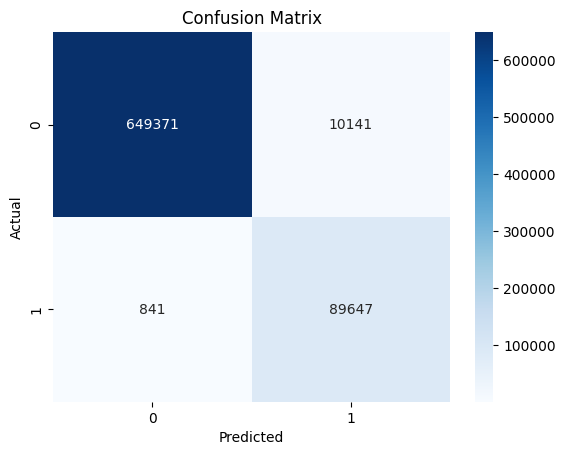

In [55]:
cm = confusion_matrix(y, prediction)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Output Prediction

In [49]:
test_predict = vote_model.predict(data_te)
test_predict

array([0., 0., 0., ..., 1., 0., 0.])

# Submission

In [50]:
Submission = pd.DataFrame({'id':data_te['id'],'y':test_predict})
Submission

,id,y
0,750000,0.0
1,750001,0.0
2,750002,0.0
3,750003,0.0
4,750004,0.0
...,...,...
249995,999995,0.0
249996,999996,0.0
249997,999997,1.0
249998,999998,0.0


In [51]:
Submission.to_csv('submission.csv',index = False)

In [52]:
Submission['y'].value_counts() 

y
0.0    222133
1.0     27867
Name: count, dtype: int64